# Facial Keypoints Detection

##### W207 Spring 2022 Section 10 
##### Team 4: Eric Sun, Jiayi Hu, Sridhar Chadalavada

### Introduction
We are using the Kaggle data set for [Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection/overview) to experiment and build models that detect the location of up to 30 key points on images of faces. These are primarily features dividing the face sagitally, for example the centers of the left and right eyes, with a smaller number of feature in the midline, such as the tip of the nose. We will be exploring convolutional neural networks (CNNs) and the impacts of tuning parameters and hyperparameters to improve score and mitigate overfitting as well as other models that may be less performant as a comprison.

#### Data
The Kaggle data sets include labeled Training and unlabeled Testing data sets. Because we do not have access to the Test labels, the predicted Test labels of our final model will be scored within Kaggle, which will evaluate our submission against those of other participants based on the root mean square errors of the predicted and original values. Our training data includes 7,049 images that we will use to divide into training and development sets, and our test data includes 1,783 images. The images are represented as a grid of 96x96 pixels in the range of (0, 255).

#### Internal Project Milestones
3/13: Baseline Submission  
3/20: Individual research and analysis into CNN modeling and transformation  
3/27: Identify chosen model parameters and experiments and merge for notebook report  
4/3: Complete final notebook  
4/10: Complete final presentation  
4/14: Final deliverable and in-class presentation  

### Initialization

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from ipywidgets import interactive
import tensorflowjs as tfjs

%matplotlib inline
pd.options.display.width = 800

In [7]:
id_lookup_table = pd.read_csv('./IdLookupTable.csv')

train = pd.read_csv('./training.csv')
print('Initial Training', train.shape)

test = pd.read_csv('./test.csv', index_col=0)
print('Initial Test', test.shape)

Initial Training (7049, 31)
Initial Test (1783, 1)


### Exploratory Data Analysis (EDA)

In [8]:
# View data

train.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


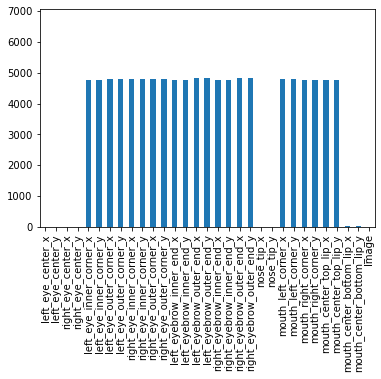

In [9]:
# Missing values

train.isnull().sum().plot(kind='bar')
plt.ylim(0, len(train))
plt.show()

# different options to fix na values
# inplace saves space but I want the flexibility to switch later without reloading the original dataset

# train_no_na = train.dropna(axis=0).copy().reset_index(drop=True)
# train_no_na = train.fillna(value=0).copy()
train_no_na = train.fillna(method='ffill').copy()


In [10]:
# Modify image data in-place

def format_string_into_list(target, from_col):
	target['image_data'] = target[from_col].map(lambda x: np.array([int(y) for y in x.split(' ')]))
	assert len(target['image_data'].map(len).unique()) == 1, f'Missing or uneven lengths in image data: {target.image_data.map(len)}' 
	assert min(target['image_data'].map(min)) >= 0, 'Negative values in image data'
	assert max(target['image_data'].map(max)) < 256, 'Unexpectedly large values in image data'

In [11]:
format_string_into_list(train_no_na, 'Image')

In [12]:
# Show face

def plot_face(index):
	plt.imshow(train_no_na.at[index, 'image_data'].reshape(96, 96), cmap='gray')
	keypoints = train_no_na.iloc[index, :~1].to_numpy()
	plt.scatter(keypoints[0::2], keypoints[1::2])
	plt.xticks([])
	plt.yticks([])
	plt.show()

interactive(plot_face, index=train_no_na.index)

interactive(children=(Dropdown(description='index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

### Model Building

In [25]:
model = tf.keras.Sequential([
	tf.keras.layers.Flatten(input_shape=(96, 96, 1)),
		tf.keras.layers.Dense(128, activation="relu"),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Dense(64, activation="relu"),
		tf.keras.layers.Dense(30)
])

In [26]:
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [27]:
x = np.concatenate(train_no_na.image_data.to_numpy()).reshape(-1, 96, 96)
y = np.concatenate(train_no_na.iloc[:,:~1].to_numpy()).reshape(-1, len(train_no_na.columns) - 2)
print(x.shape, y.shape)
model.fit(x, y, epochs=5)


(7049, 96, 96) (7049, 30)


ValueError: Error when checking input: expected flatten_2_input to have 4 dimensions, but got array with shape (7049, 96, 96)

### Analysis of Predictions

In [21]:
format_string_into_list(test, 'Image')

In [24]:
x = np.concatenate(test.image_data.to_numpy()).reshape(-1, 96, 96)
y = model.predict(x)

ValueError: Error when checking input: expected flatten_1_input to have 4 dimensions, but got array with shape (1783, 96, 96)

In [13]:
# Show face

def plot_face2(index):
	plt.imshow(test.at[index, 'image_data'].reshape(96, 96), cmap='gray')
	predicted_kp = y[index]
	plt.scatter(predicted_kp[0::2], predicted_kp[1::2], color='red')
	plt.xticks([])
	plt.yticks([])
	plt.show()

interactive(plot_face2, index=test.index)

interactive(children=(Dropdown(description='index', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

### Export model into TFJS

In [15]:
tfjs.converters.save_keras_model(model, 'tfjs_model', weight_shard_size_bytes=999999999)